## Importing necessary modules

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2022-06-12 08:59:50.875238: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-12 08:59:50.875336: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Creating necessary constants for future use

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

Creating a Dataset from the given pre-defined data

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle =True,
    image_size =(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


2022-06-12 09:00:17.132935: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-12 09:00:17.133040: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-12 09:00:17.133110: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (inspiron-3576): /proc/driver/nvidia/version does not exist
2022-06-12 09:00:17.169124: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

2022-06-12 09:00:21.109491: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.


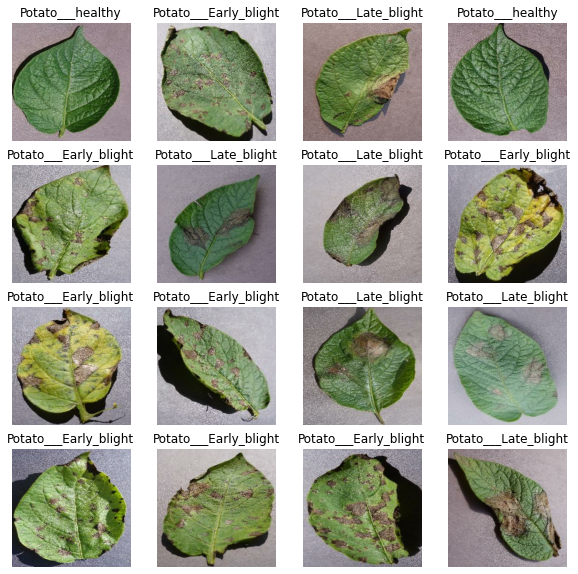

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

Splitting dataset into training and test dataset, where -->
training size = 80%
validaiton size = 10%
test size = 10%

In [7]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [8]:
train_ds = dataset.take(54)
len(train_ds)

54

In [9]:
# test_ds = dataset.skip(54) # skip the first 54 samples, as they are in train dataset
# len(test_ds)

In [10]:
val_test_size = 0.1
len(dataset)*val_test_size

6.800000000000001

In [11]:
skip_ds = dataset.skip(54)
val_ds = skip_ds.take(6)
len(val_ds)

6

In [12]:
test_ds = skip_ds.skip(6)
len(test_ds)

8

Main function to break the full dataset into smaller sized batches, and split them into training, validation and test dataset

In [13]:
def dataset_partitioning(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = dataset_partitioning(dataset)

In [15]:
len(train_ds)

54

In [16]:
len(test_ds)

8

In [17]:
len(val_ds)

6

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


Preprocessing the data, by creating necessary layers and applying necessary preprocessing techniques

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255) # this is done to, scale the RGB calues
])

In [20]:
# Preprocessing done to flip and rotate images, so as to remove any anomalies
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

Creating the Neural Network Model

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
54/54 [==============================] - 77s 1s/step - loss: 0.8483 - accuracy: 0.5521 - val_loss: 0.6631 - val_accuracy: 0.7083
Epoch 2/10
54/54 [==============================] - 70s 1s/step - loss: 0.4674 - accuracy: 0.8021 - val_loss: 0.3196 - val_accuracy: 0.8385
Epoch 3/10
54/54 [==============================] - 68s 1s/step - loss: 0.2784 - accuracy: 0.8906 - val_loss: 0.2310 - val_accuracy: 0.9115
Epoch 4/10
54/54 [==============================] - 68s 1s/step - loss: 0.2228 - accuracy: 0.9184 - val_loss: 0.1826 - val_accuracy: 0.9375
Epoch 5/10
54/54 [==============================] - 68s 1s/step - loss: 0.1854 - accuracy: 0.9317 - val_loss: 0.1517 - val_accuracy: 0.9375
Epoch 6/10
54/54 [==============================] - 68s 1s/step - loss: 0.1634 - accuracy: 0.9404 - val_loss: 0.1335 - val_accuracy: 0.9219
Epoch 7/10
54/54 [==============================] - 68s 1s/step - loss: 0.1711 - accuracy: 0.9346 - val_loss: 0.2126 - val_accuracy: 0.9167
Epoch 8/10
54/54 [==

Save the Model

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

In [ ]:
model.save("../potatoes.h5")

## Bring the saved Model, and use it

In [20]:
import os

model_num = max([int(i) for i in os.listdir("../saved_models") + [0]])
print(model_num)

1


In [21]:
!pwd
model = tf.keras.models.load_model('../potatoes.h5')

/home/euhid/Extra-Learning/DeepLearning/PotatoPlant-DiseaseClassifier/training


In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [23]:
scores = model.evaluate(test_ds)

2022-06-12 09:01:43.546265: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.
2022-06-12 09:01:43.724925: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.
2022-06-12 09:01:43.911179: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.
2022-06-12 09:01:44.368781: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.
2022-06-12 09:01:53.894013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 49 of 10000
2022-06-12 09:01:56.253820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-06-12 09:01:56.319122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-06-12 09:01:56.319203: I tenso

8/8 [==============================] - 19s 295ms/step - loss: 0.1078 - accuracy: 0.9648


Continue with Model inference and other necessary functions

In [24]:
scores

[0.10776589810848236, 0.96484375]

In [25]:
model

In [ ]:
model.params

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Plotting a Training vs Validation Accuracy  and Loss metrics

In [ ]:
plt.figure(figsize = (8,8))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training vs Validation Loss')
plt.show()

## Model Inferencing

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")